In [1]:
# Setup autoreload and add parent dir to sys.path
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0,'..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import make_deterministic
import tensorflow as tf
import gpflow
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

plt.rcParams['font.size']=18
make_deterministic()
dtype=np.float64
save_figs = True

2022-08-14 15:00:24.690753: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
N = 200  # Number of training observations
def func(x):
    return np.sin(x * 6) + 0.3 * np.cos(x * 2) + 0.5 * np.sin(15*x)

X = np.random.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * np.random.randn(N, 1)  # Noisy Y values
X = X.astype(dtype)
Y = Y.astype(dtype)

# clip to -2:2 for bounded sensitivity
Y = np.clip(Y, -2, 2)

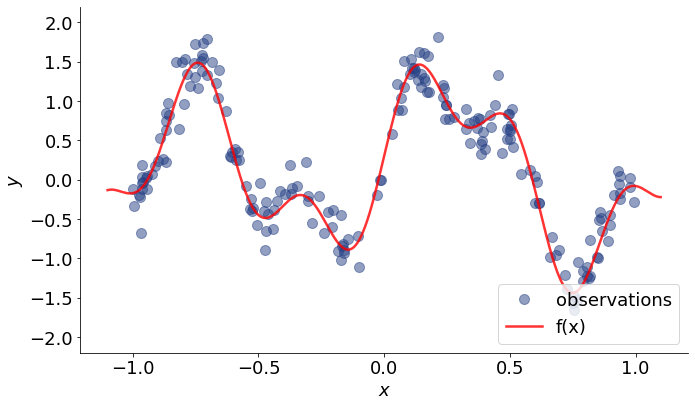

In [4]:
plt.figure(figsize=(10, 6))
ylim=(-2.2, 2.2)
plt.plot(X, Y, ".", label="observations", alpha=0.5, markersize='20',color='#264185')
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, alpha=0.8, lw=2.5, c='red', label='f(x)')
sns.despine()
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim(ylim)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
plt.savefig("../figures/local_dp/underlying_func.pdf") if save_figs else 0

## Applying Local DP to the labels $y$
We need to normalize $y$ and then apply Laplace noise proportional to $\Delta(y)$: 
$$y_i + \text{Lap}(0, \frac{\Delta(y)}{\varepsilon}$$

In [5]:
from dp_gp.dp_tools.mechanisms import laplace_mechanism, gauss_mechanism
x_priv_all = laplace_mechanism(X, 10.0, 0.0, 2)
y_priv_all = laplace_mechanism(Y, 10.0, 0.0, 4)
y_priv = laplace_mechanism(Y, 10.0, 0.0, 4)

Adding independent Laplace noise with scale=0.2000
Adding independent Laplace noise with scale=0.4000
Adding independent Laplace noise with scale=0.4000


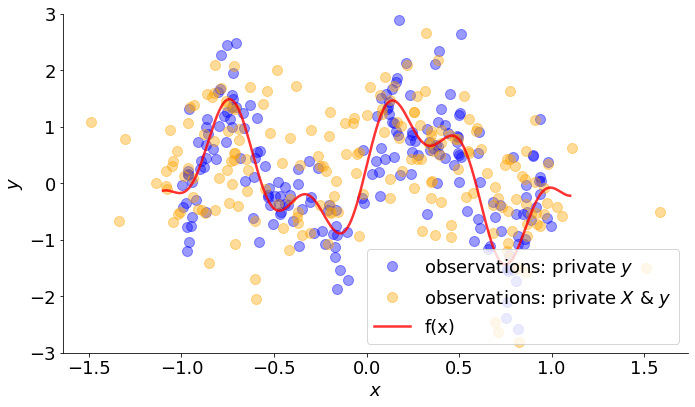

In [6]:
plt.figure(figsize=(10, 6))
ylim=(-3, 3)
plt.plot(X, y_priv, ".", label="observations: private $y$", alpha=0.4, markersize='20',color='blue')
plt.plot(x_priv_all, y_priv_all, ".", label="observations: private $X$ & $y$", alpha=0.4, ms='20',color='orange')
Xt = np.linspace(-1.1, 1.1, 1000)[:, None]
Yt = func(Xt)
_ = plt.plot(Xt, Yt, alpha=0.8, lw=2.5, c='red', label='f(x)')
sns.despine()
plt.legend(loc='lower right')
plt.tight_layout()
plt.ylim(ylim)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
plt.savefig("../figures/local_dp/local_dp_func_samples.pdf") if save_figs else 0

## GP inference with private targets

In [7]:
gpr_model = gpflow.models.GPR((X, y_priv), kernel=gpflow.kernels.SquaredExponential())
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr_model.training_loss, gpr_model.trainable_variables, options=dict(maxiter=100))
print(opt_logs)
mu_pred, var_pred = gpr_model.predict_y(X)

2022-08-14 15:00:27.960054: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-14 15:00:27.960101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: moritz-HP-Z4-G4-Workstation
2022-08-14 15:00:27.960110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: moritz-HP-Z4-G4-Workstation
2022-08-14 15:00:27.960273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-08-14 15:00:27.960301: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-08-14 15:00:27.960307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-08-14 15:00:27.961038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) 

      fun: 203.86917279686742
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00069053,  0.00015856,  0.00134862])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 23
      nit: 15
     njev: 23
   status: 0
  success: True
        x: array([-2.04424572, -0.15031939, -0.8273565 ])


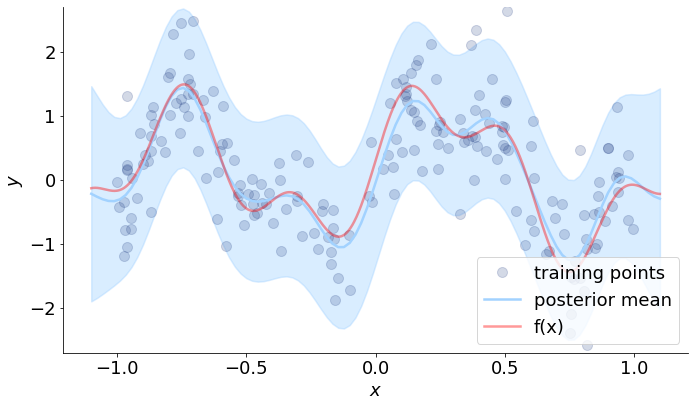

In [8]:
from utils import plot_model
plot_model(gpr_model, (X, y_priv), is_svgp=False, ms='20', predict_y=True)
_ = plt.plot(Xt, Yt, alpha=0.4, lw=2.5, c='red', label='f(x)')
plt.legend(loc='lower right')
plt.ylim((-2.7, 2.7))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
plt.savefig("../figures/local_dp/local_dp_targets_gp_pred.pdf") if save_figs else 0

##  Fully private setting

In [9]:
gpr_model = gpflow.models.GPR((x_priv_all, y_priv_all), kernel=gpflow.kernels.SquaredExponential())
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(gpr_model.training_loss, gpr_model.trainable_variables, options=dict(maxiter=200))
print(opt_logs)
mu_pred, var_pred = gpr_model.predict_y(x_priv_all)

      fun: 262.4786239744814
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.78989916e-07,  3.60113490e-06, -4.11083291e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 23
      nit: 15
     njev: 23
   status: 0
  success: True
        x: array([-1.25840758, -1.44728946,  0.10527789])


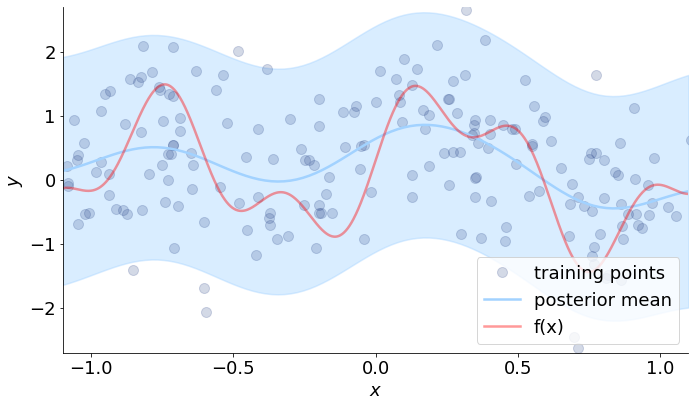

In [10]:
from utils import plot_model
plot_model(gpr_model, (x_priv_all, y_priv_all), is_svgp=False, ms='20', predict_y=True)
_ = plt.plot(Xt, Yt, alpha=0.4, lw=2.5, c='red', label='f(x)')
plt.legend(loc='lower right')
plt.xlim((-1.1, 1.1))
plt.xticks([-1, -0.5, 0.0, 0.5, 1.0])
plt.ylim((-2.7, 2.7))
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.tight_layout()
plt.savefig("../figures/local_dp/local_dp_full_gp_pred.pdf") if save_figs else 0